## <center>**Notebook <span style= 'color: #FDCA40'>introduction</span>**

In this section of the project I am going to anwser some of the questions we asked espicially the ones<br>
those can be putted into a report which are the following:
1. Ratio change between Budget & Revenue each decade.
1. Ratio change between Budget & Revenue per each genere.
1. What are the most common words in movies overview per each of the top 3 popular genres. <sub>*(Just because it looks cool)</sub>
1. How do the revenue & the budget correlate after 21 century.
1. How much does the runtime of a movie correlate with it's rating.

For more questions please view the Tableau dashboard or the web version of this report and now with the report creation.

## <center>**<span style= 'color: #FDCA40'>Importing</span> the packeges**

In [294]:
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import seaborn           as sns
import pandas            as pd
import numpy             as np

from matplotlib.ticker import FuncFormatter
from wordcloud         import ImageColorGenerator
from itertools         import zip_longest
from wordcloud         import WordCloud
from wordcloud         import STOPWORDS
from datetime          import datetime
from pandasql          import sqldf
from PIL               import Image

import matplotlib
import requests
import warnings
import ast
import cv2

In [295]:
%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Dubai'

PAD              :int  = 25
FONT             :int  = 25
COLORS           :list = ['#080708', '#3772FF', '#DF2935', '#FDCA40', '#c2c2c2']

## <center>**Reading the<span style= 'color: #FDCA40'> data</span>**

In [296]:
df                  = pd.read_parquet('../data-cleaning/cleaned-data/movies-data.parquet')
df_without_outliers = pd.read_parquet('../data-cleaning/cleaned-data/movies-data-without-outliers.parquet')

In [297]:
cm = sns.light_palette(COLORS[1], as_cmap=True)

display(df.drop(['overview', 'genres', 'production_companies'], axis= 1)
        .sample(5).style.background_gradient(cmap= cm))

In [298]:
display(df.drop(['overview', 'genres', 'production_companies'], axis= 1)
        .sample(5).style.highlight_null(color= COLORS[2]))

# Parquet files don't load the Nans

In [299]:
cm = sns.light_palette(COLORS[3], as_cmap=True)
df.describe().style.background_gradient(cmap= cm)

In [300]:
cm = sns.light_palette(COLORS[3], as_cmap=True)
df_without_outliers.describe().style.background_gradient(cmap= cm)

In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968 entries, 0 to 967
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   movie_id              968 non-null    uint32        
 1   movie_title           968 non-null    object        
 2   overview              968 non-null    object        
 3   popularity            968 non-null    uint16        
 4   rating                968 non-null    float32       
 5   tagline               968 non-null    object        
 6   runtime               968 non-null    uint16        
 7   revenue               968 non-null    uint32        
 8   release_date          968 non-null    datetime64[ns]
 9   vote_count            968 non-null    uint32        
 10  budget                968 non-null    uint32        
 11  genres                968 non-null    object        
 12  production_companies  968 non-null    object        
dtypes: datetime64[ns](1)

## <center>**Visualizing the<span style= 'color: #FDCA40'> data</span>**

#### **Question 1 & 2:**

In [302]:
data = df_without_outliers.copy()
data[['budget', 'revenue']] = data[['budget', 'revenue']].dropna()

bins   = list(range(1970, 2031, 10))
labels = [f"{x}-{x+9}" for x in bins[:-1]]

data = pd.DataFrame({'budget_to_revenue': data['budget'] / data['revenue'],
                     'release_decade'   : pd.cut(data['release_date'].dt.year, bins=bins, labels=labels, right=False),
                     'genres'           : data['genres'].astype(str)})

data = data.replace([np.inf, 0], np.nan).dropna().reset_index(drop= True)
data = data.drop(tucky_method(data['budget_to_revenue'].to_numpy()))


# Preparing for the first question
data_1 = data.drop(['genres'], axis= 1).copy()
data_1 = data_1.groupby('release_decade', as_index= False).mean()


# Preparing for the second question
data_2           = data.drop(['release_decade'], axis= 1).copy()
data_2['genres'] = data['genres'].apply(lambda s: [genre.strip("'") for genre in s.strip('[]').split(' \'')])

data_2           = data_2.explode('genres').groupby('genres', as_index= False).mean()
data_2           = pd.concat([data_2.sort_values(by='budget_to_revenue', ascending= False).head(3),
                              data_2.sort_values(by='budget_to_revenue', ascending= True).head(3)]
                            ).reset_index(drop=True)

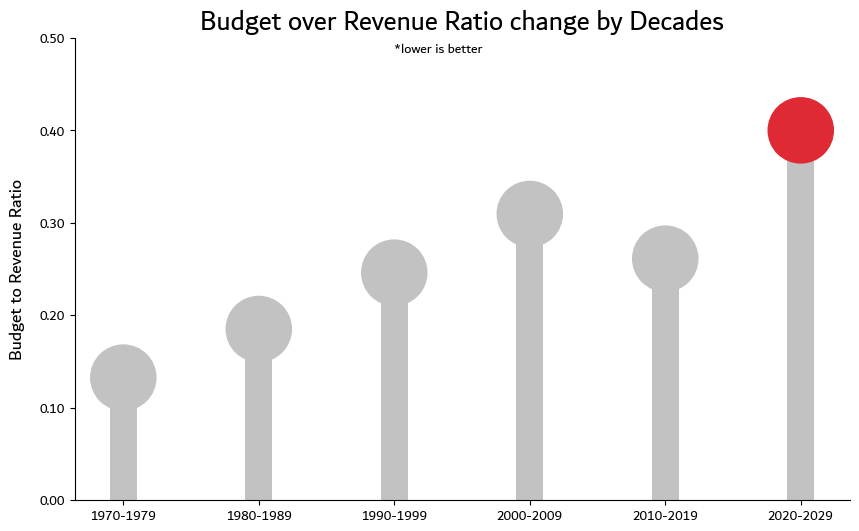

In [303]:
fig, ax = plt.subplots()

x = data_1['release_decade']
y = data_1['budget_to_revenue']

temp_colors = [COLORS[-1]] * 5
temp_colors += [COLORS[2]]

ax.bar     (x, y, width= 0.2, color= COLORS[-1])
ax.scatter (x, y, s= 2200, c= temp_colors)


ax.spines[['right', 'top']].set_visible(False)
ax.set_yticks(np.arange(0, max(y) * 1.5, step= max(y) / 4))

ax.set_ylabel('Budget to Revenue Ratio', labelpad= 10, fontsize= 13)
ax.set_title('Budget over Revenue Ratio change by Decades', fontsize= FONT*.8)
ax.annotate(xy=(2, 0.48), text='*lower is better')


plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda v, _: f'{v:.2f}'))
fig.set_size_inches(10, 6)

plt.savefig('../plots/budget-over-revenue-ratio-change.png')
plt.show()

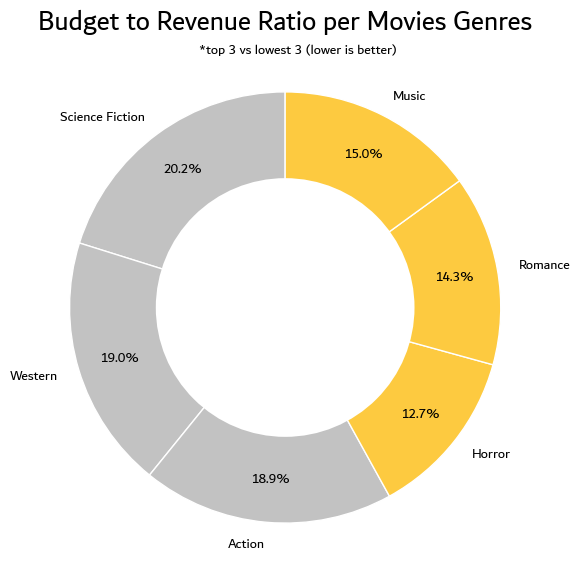

In [308]:
fig, ax = plt.subplots()

labels = data_2['genres']
values = data_2['budget_to_revenue']

temp_colors = [COLORS[-1]] * 3
temp_colors += [COLORS[3]] * 3

wedgeprops = {'edgecolor': 'white', 'linewidth': 1}


plt.pie(x= values, labels= labels, autopct='%2.1f%%',
        pctdistance=0.8, labeldistance=1.1,
        startangle=90, colors= temp_colors,
        wedgeprops= wedgeprops)

centre_circle = plt.Circle((0, 0), 0.6, fc='white')
ax.add_artist(centre_circle)

ax.set_title('Budget to Revenue Ratio per Movies Genres', fontsize= FONT*.8)
ax.annotate(xy=(-0.4, 1.18), text='*top 3 vs lowest 3 (lower is better)')

fig.set_size_inches(7, 7)

plt.savefig('../plots/budget-over-revenue-by-genre.png')
plt.show()

#### **Question 3:**

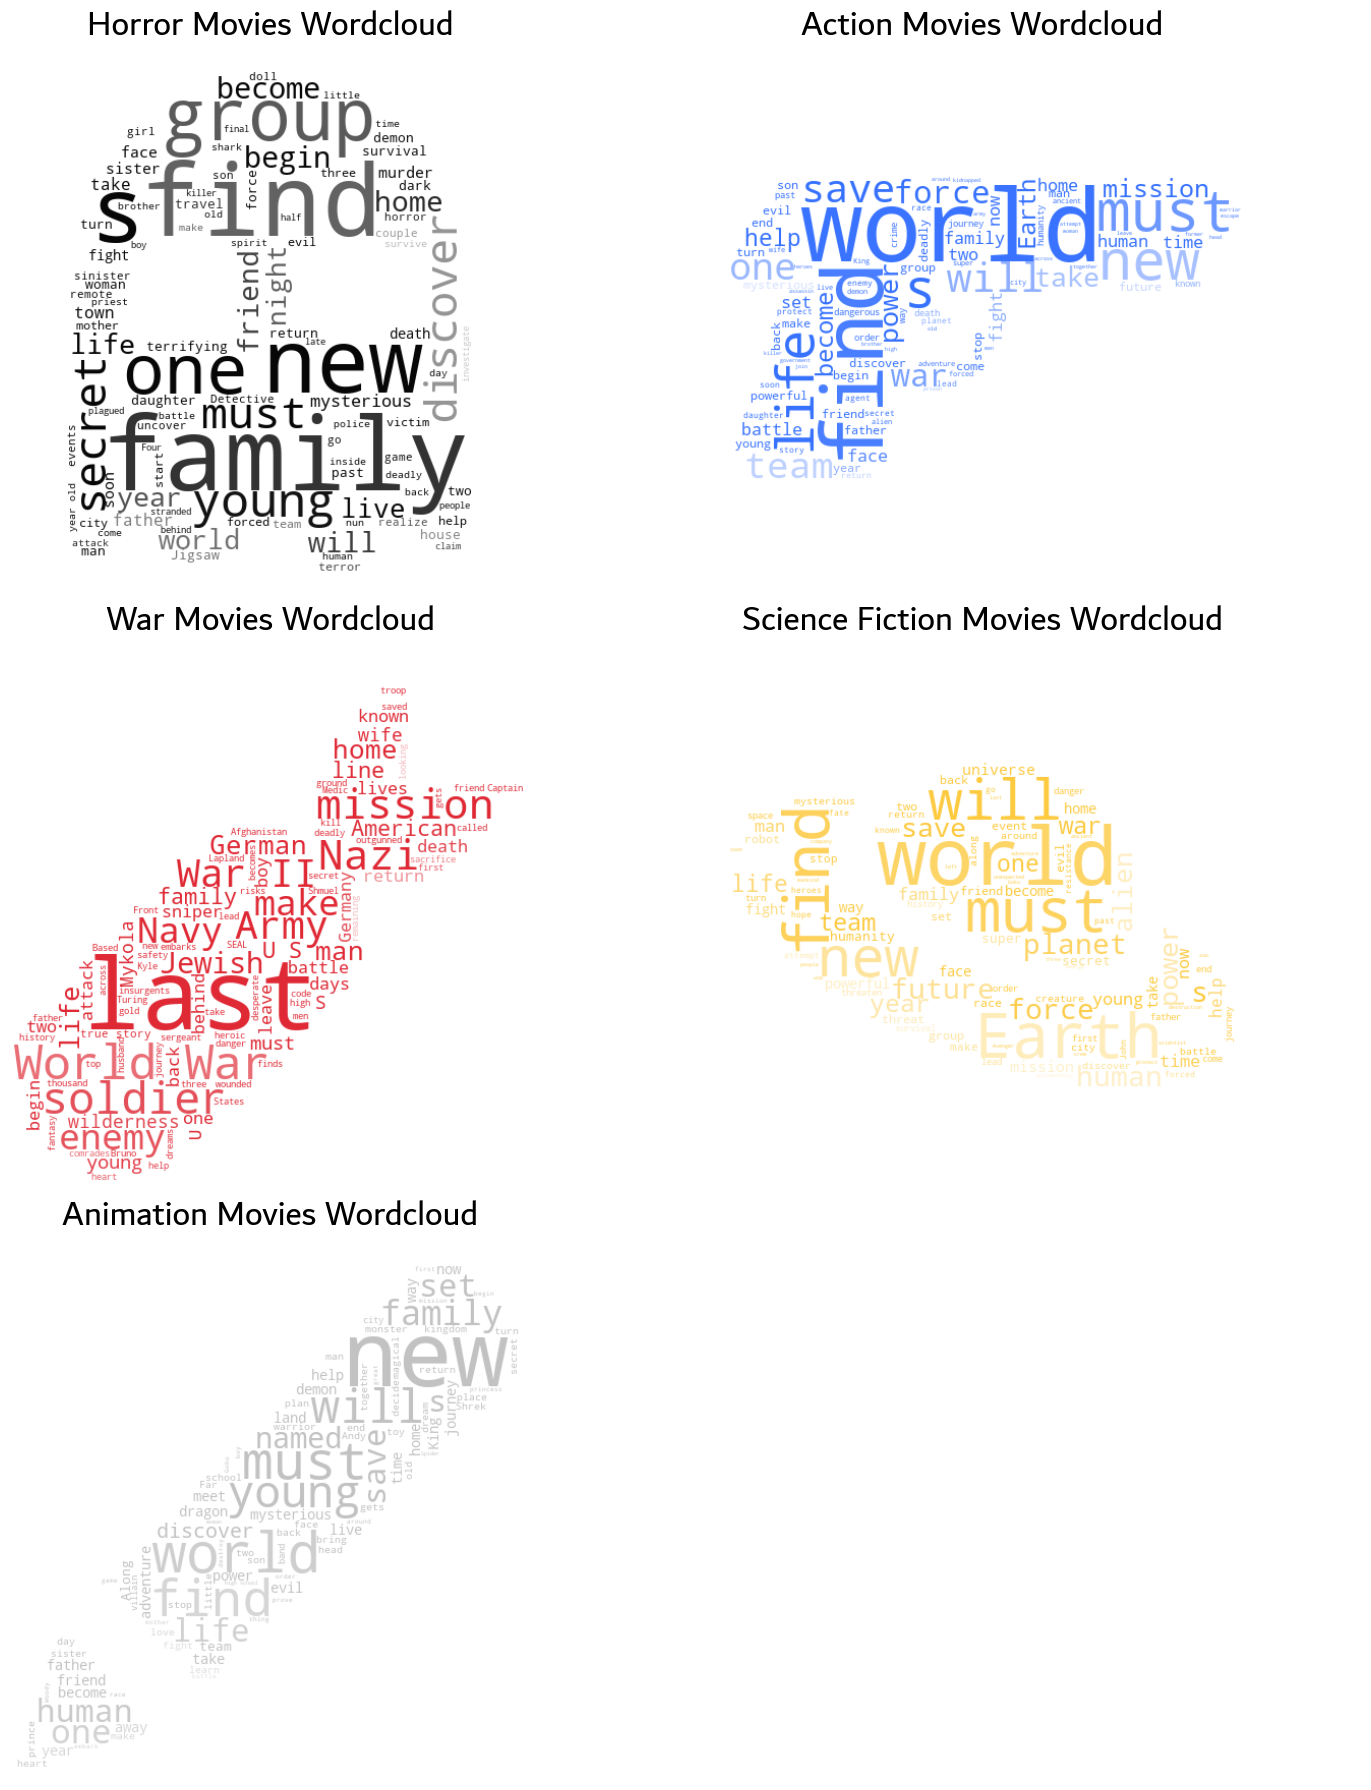

In [315]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
mask_paths = ['../imgs/assets/ghost.png',     '../imgs/assets/gun.png',
              '../imgs/assets/bomb.png',       '../imgs/assets/ufo.png',
              '../imgs/assets/pen.png']

top_5_genres = (df_without_outliers[['genres', 'popularity']]
                .explode('genres').groupby('genres', as_index=False)
                .mean().sort_values(by='popularity', ascending=False).head(5))['genres']

for ax, color, genre, mask_path in zip_longest(axes, COLORS, top_5_genres, mask_paths, fillvalue=None):

    if genre is not None:
        
        mask = cv2.imread(mask_path)
        
        hex_color = color.lstrip("#")
        desired_color = [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]

        colormap = np.zeros((256, 1, 3), dtype=np.uint8)

        for i in range(256):
            intensity = i / 255.0
            
            if i < 10:
                colormap[i] = desired_color
            elif i == 255:
                colormap[i] = [255, 255, 255]
            else:
                colormap[i] = [
                    int(desired_color[0] * intensity),
                    int(desired_color[1] * intensity),
                    int(desired_color[2] * intensity)]
            
        mask       = cv2.applyColorMap(mask, colormap)        
        text       = ' '.join(df[df['genres'].apply(lambda l: genre in l)]['overview'])
        color_func = ImageColorGenerator(mask)

        wordcloud = WordCloud(
            background_color= 'white',
            mask=             mask,
            stopwords=        STOPWORDS,
            width=            800,
            height=           800,
            max_words=        100,
            max_font_size= 100).generate(text).recolor(color_func=color_func)

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'{genre} Movies Wordcloud', fontsize= FONT, pad= PAD)

    ax.axis('off')

fig.set_size_inches(15, 18)
plt.tight_layout()

plt.savefig('../plots/movies-genres-wordclouds.png')
plt.show()

#### **Question 4:**

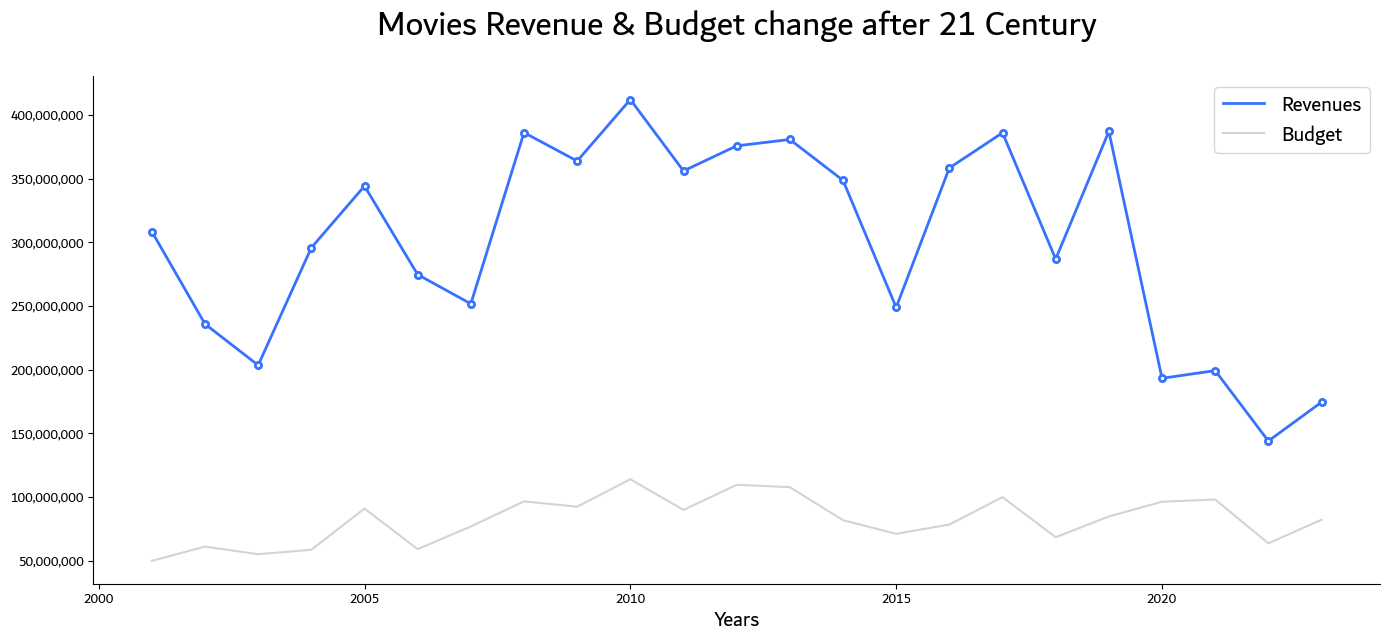

In [306]:
fig, ax = plt.subplots()

df_without_outliers['release_year'] = df_without_outliers['release_date'].dt.year

df_by_year = df_without_outliers[(df_without_outliers['revenue'] > 0) & 
                                 (df_without_outliers['release_year'] > 2000) &
                                 (df_without_outliers['budget'] > 0)
                                ].groupby('release_year')


ax.plot(df_by_year['revenue'].mean().index,
        df_by_year['revenue'].mean(),
        color= COLORS[1], lw=2.0, zorder=10,
        label= 'Revenues')

ax.scatter(df_by_year['revenue'].mean().index,
           df_by_year['revenue'].mean(),
           fc='w', ec= COLORS[1], s=20, lw=2.0, zorder=12)



ax.plot(df_by_year['budget'].mean().index,
        df_by_year['budget'].mean(),
        color='lightgrey', lw=1.5,
        label= 'Budget')


ax.spines[['right', 'top']].set_visible(False)

ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ',')))


ax.set_title('Movies Revenue & Budget change after 21 Century', fontsize=FONT, pad=30)

ax.set_xlabel('Years', fontsize=FONT*3/5)


plt.legend(fontsize= FONT*3/5)
fig.set_size_inches(14, 6.5)
plt.tight_layout()

plt.savefig('../plots/revenue-and-budget-growth.png')
plt.show()

#### **Question 5:**

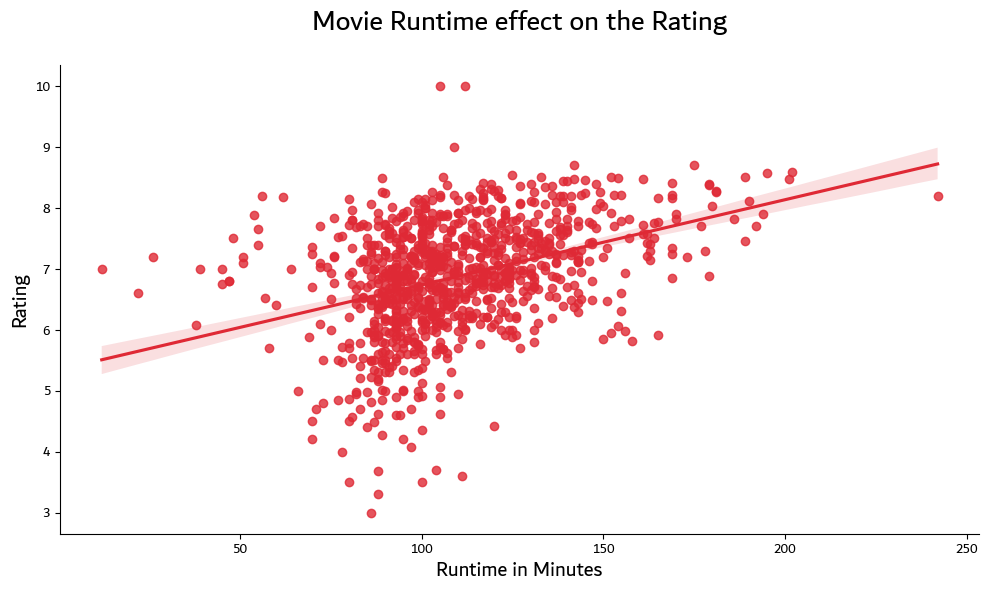

In [307]:
fig, ax = plt.subplots()

sns.regplot(data= df[df['rating'] > 2],
            x='runtime', y='rating', color= COLORS[2], ax= ax)

ax.spines[['right', 'top']].set_visible(False)



ax.set_xlabel('Runtime in Minutes', fontsize=FONT*3/5)
ax.set_ylabel('Rating', fontsize=FONT*3/5)

ax.set_title('Movie Runtime effect on the Rating', fontsize= FONT*5/6, pad= PAD)

fig.set_size_inches(10, 6)
plt.tight_layout()

plt.savefig('../plots/runtime-and-rating-corr.png')
plt.show()